# ----------------- ENSEMBLE METHODS

## AdaBoost

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from imblearn.datasets import make_imbalance
from collections import defaultdict
from yellowbrick.contrib.classifier import DecisionViz
from sklearn.decomposition import PCA
from itertools import product
from yellowbrick.datasets import load_credit
from yellowbrick.features import PCA as yPCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score 
from scikitplot.metrics import plot_precision_recall, plot_roc, plot_cumulative_gain, plot_lift_curve
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import KFold
from sklearn import tree
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, classification_report

Using TensorFlow backend.
C:\Users\Federica\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Federica\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Federica\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Federica\Anaconda3\lib\site-packages\tensorflow\python\framewo

In [2]:
# Dataset con attributi originali
df = pd.read_csv("dataset_All_normalized.csv")
class_name = 'Occupancy'

In [3]:
df.head()

,Temperature,Light,CO2,HumidityRatio,Day,Afternoon,Evening,Night,Weekday,Weekend,Occupancy
0,0.869029,0.603964,0.208231,0.549737,0,1,0,0,1,0,1
1,0.872357,0.596946,0.215163,0.551972,0,1,0,0,1,0,1
2,0.874576,0.591029,0.220898,0.549997,0,1,0,0,1,0,1
3,0.873190,0.509582,0.224045,0.544374,0,1,0,0,1,0,1
4,0.879014,0.504267,0.226675,0.550376,0,1,0,0,1,0,1


In [4]:
y = df['Occupancy']
X = df.drop(columns=['Occupancy'])

In [5]:
# Funzione che viene chiamata sul:
# - y_true: target reale
# - y_pred: target predetto dal classificatore
# stampa: matrice di confusione, accuracy, precision, recall, specificity, F1
def result_pred(y_true, y_pred):
    print("**** Matrice di Confusione *****")
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    print(' True negative: %d False negative: %d' % (tn, fn))
    print(' True positive: %d False positive: %d' % (tp, fp))
    print("____________________________________________")

    # Calcolo dell'accuracy
    print("***** Calcolo dell'accuracy *****")
    accuracy = accuracy_score(y_true, y_pred)    
    print('Frazione di campioni correttamente correlati: %0.4f' % accuracy)
    accuracy = accuracy_score(y_true, y_pred, False)
    print("Numero di campioni correttamente correlati: ", accuracy)    
    print("____________________________________________")

    # Calcolo della precision
    print("**** Calcolo della precisione *****")
    #Percentuale di classificazioni positive che sono corrette
    #se dico "positivo" dico giusto?
    precision = precision_score(y_true, y_pred)
    print('Percentuale di classificazioni positive che sono corrette: %0.4f' % precision)   
    print("____________________________________________")    

    # Calcolo della recall
    print("**** Calcolo della recall (sensitivity) *****")
    recall = recall_score(y_true, y_pred)
    print('Percentuale di elementi positivi del testing set che sono stati classificati come positivi: %0.4f' % recall)
    print("____________________________________________")    

    # Calcolo della specificity
    print("**** Calcolo della specificity *****")
    specificity = tn / (tn+fp)
    print('Percentuale di elementi negativi del testing set che sono stati classificati come negativi: %0.4f' % specificity)
    print("____________________________________________")   
    
    # Calcolo dell'F1 score
    print("**** Calcolo della F1 score *****")
    f1 = f1_score(y_true, y_pred)
    #Il punteggio F1 può essere interpretato come una media ponderata della precisione e della recall, 
    #in cui un punteggio F1 raggiunge il suo valore migliore a 1 e il punteggio peggiore a 0.
    print('F1 scores: %0.4f' % f1)
    print("____________________________________________")   
    
    # Stampiamo le stesse statistiche dalla funzione report
    print(classification_report(y_test, y_pred))
    
    print("Con le tecniche viste finora non viene fornita nessuna informazione sulla “gravità” degli errori (“errore lieve” oppure “errore grave)")
    print("per questo si usano la curva CMC, la curva ROC")

In [6]:
# Prima di chiamare questa funzione dobbiamo aver
# scritto in y_pred il valore di ".predict" che come output fornirà 0 o 1
# dentro a y_score il valore di ".predict_proba" che darà solo la probabilità di 1
def plot_res(y_pred, y_score, y_test):
    #ROC CURVE: implementazione legata esclusivamente all'attività di classificazione binaria
    #false positive rate, true positive rate
    print("****** ROC CURVE + AUC?: passo passo *******")
    fprate, tprate, threashold = roc_curve(y_test, y_score[:, 1])
    auc_score = auc(fprate, tprate)
    plt.plot(fprate, tprate, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (auc_score))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.title('ROC curve', fontsize=16)
    plt.legend(loc="lower right", fontsize=14, frameon=False)
    plt.tick_params(axis='both', which='major', labelsize=16)
    plt.show()

    print("____________________________________")
    print("****** VALORE DI AUC *******")    
    print(roc_auc_score(y_test, y_score[:,1]))    
    
    print("____________________________________")
    print("****** ROC CURVE: con metodo diretto *******")
    plot_roc(y_test, y_score)
    plt.show()
    
    print("____________________________________")
    print("****** Precision recall: con metodo diretto *******")
    plot_precision_recall(y_test, y_score)
    plt.show()
    

    print("____________________________________")
    print("****** Cumulative gain: con metodo diretto *******")
    plot_cumulative_gain(y_test, y_score)
    plt.show()
    
    
    print("____________________________________")
    print("****** Lift curve: con metodo diretto *******")    
    plot_lift_curve(y_test, y_score)
    plt.show()

In [7]:
import pandas as pd
import numpy as np
import warnings
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

In [8]:
attributes = ['Light','CO2','HumidityRatio', 'Day']
y = df['Occupancy']
X = df[attributes]
# Split the dataset in two equal parts
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1000, stratify = y)

# Set the parameters by cross-validation
tuned_parameters = {
    'n_estimators': [5, 10, 25, 50, 100],
    'learning_rate' : [0.1, 0.25, 0.5, 0.75, 1],
 }

#scores = ['precision', 'recall', 'f1']
scores = ['accuracy']

for score in scores:
    print("# Tuning hyper-parameters for ----> %s" % score)
    print()
    
    obj = AdaBoostClassifier(GaussianNB())
    
    clf = GridSearchCV(obj, tuned_parameters, cv=5, scoring=score)
   
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()

# Tuning hyper-parameters for ----> accuracy

Best parameters set found on development set:

{'learning_rate': 0.5, 'n_estimators': 5}

Grid scores on development set:

0.986 (+/-0.002) for {'learning_rate': 0.1, 'n_estimators': 5}
0.987 (+/-0.002) for {'learning_rate': 0.1, 'n_estimators': 10}
0.986 (+/-0.002) for {'learning_rate': 0.1, 'n_estimators': 25}
0.986 (+/-0.002) for {'learning_rate': 0.1, 'n_estimators': 50}
0.986 (+/-0.001) for {'learning_rate': 0.1, 'n_estimators': 100}
0.987 (+/-0.002) for {'learning_rate': 0.25, 'n_estimators': 5}
0.987 (+/-0.002) for {'learning_rate': 0.25, 'n_estimators': 10}
0.987 (+/-0.001) for {'learning_rate': 0.25, 'n_estimators': 25}
0.986 (+/-0.002) for {'learning_rate': 0.25, 'n_estimators': 50}
0.985 (+/-0.002) for {'learning_rate': 0.25, 'n_estimators': 100}
0.987 (+/-0.002) for {'learning_rate': 0.5, 'n_estimators': 5}
0.987 (+/-0.003) for {'learning_rate': 0.5, 'n_estimators': 10}
0.986 (+/-0.003) for {'learning_rate': 0.5, 'n_estimators':

**** Matrice di Confusione *****
 True negative: 4677 False negative: 7
 True positive: 1418 False positive: 66
____________________________________________
***** Calcolo dell'accuracy *****
Frazione di campioni correttamente correlati: 0.9882
Numero di campioni correttamente correlati:  6095
____________________________________________
**** Calcolo della precisione *****
Percentuale di classificazioni positive che sono corrette: 0.9555
____________________________________________
**** Calcolo della recall (sensitivity) *****
Percentuale di elementi positivi del testing set che sono stati classificati come positivi: 0.9951
____________________________________________
**** Calcolo della specificity *****
Percentuale di elementi negativi del testing set che sono stati classificati come negativi: 0.9861
____________________________________________
**** Calcolo della F1 score *****
F1 scores: 0.9749
____________________________________________
              precision    recall  f1-score   

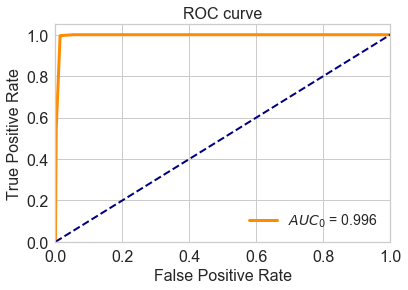

____________________________________
****** VALORE DI AUC *******
0.9955684277106429
____________________________________
****** ROC CURVE: con metodo diretto *******


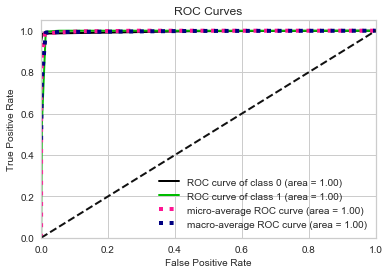

____________________________________
****** Precision recall: con metodo diretto *******


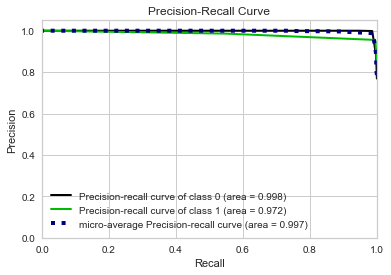

____________________________________
****** Cumulative gain: con metodo diretto *******


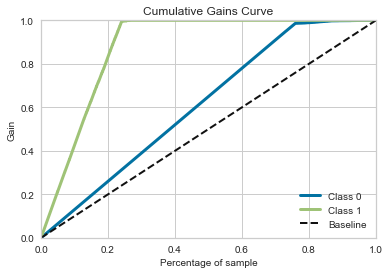

____________________________________
****** Lift curve: con metodo diretto *******


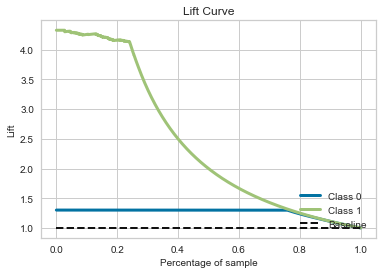

In [9]:
attributes = ['Light','CO2','HumidityRatio', 'Day']
y = df['Occupancy']
X = df[attributes]
# Split the dataset in two equal parts
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1000, stratify = y)

clf = AdaBoostClassifier(learning_rate= 0.5, n_estimators= 5)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
result_pred(y_test, y_pred)
y_score = clf.predict_proba(X_test)
plot_res(y_pred, y_score, y_test)

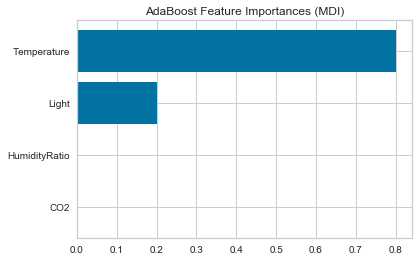

In [11]:
feature_names = ["Temperature", "Light", "CO2", "HumidityRatio", "Day", "Afternoon", "Evening", "Night", "Weekday", "Weekend"]
nbr_features = 10

tree_feature_importances = clf.feature_importances_
sorted_idx = tree_feature_importances.argsort()[-nbr_features:]

y_ticks = np.arange(0, len(sorted_idx))
fig, ax = plt.subplots()
plt.barh(y_ticks, tree_feature_importances[sorted_idx])
plt.yticks(y_ticks, np.array(feature_names)[sorted_idx])
plt.title("AdaBoost Feature Importances (MDI)")
plt.show()

In [21]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error

params = {'n_estimators': 5, 
          'learning_rate': 0.5}
clf = ensemble.AdaBoostClassifier(**params)

clf.fit(X_train, y_train)
mse = mean_squared_error(y_test, clf.predict(X_test))
print("MSE: %.4f" % mse)
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)

for i, y_pred in enumerate(clf.staged_predict(X_test)):
    test_score[i] = clf.predict(X_test)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, clf.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')

MSE: 0.0118


ValueError: setting an array element with a sequence.

## AdaBoost + Oversampling

In [10]:
import warnings
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.ensemble import AdaBoostClassifier
from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.over_sampling import RandomOverSampler

In [54]:
from collections import Counter
attributes = ['Light','CO2','HumidityRatio', 'Day']
y = df['Occupancy']
X = df[attributes]
ros = RandomOverSampler(random_state=42)
X_res, y_res = ros.fit_resample(X, y)
print('Resampled dataset shape %s' % Counter(y_res))

# Split the dataset in two equal parts
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.3, random_state=1000, stratify = y_res)

# Set the parameters by cross-validation
tuned_parameters = {
    'n_estimators': [1, 5, 10, 25, 50, 100],
    'learning_rate' : [0.1, 0.25, 0.5, 0.75, 1],
 }

#scores = ['precision', 'recall', 'f1']
scores = ['accuracy']

for score in scores:
    print("# Tuning hyper-parameters for ----> %s" % score)
    print()
    
    obj = AdaBoostClassifier(GaussianNB())
    
    clf = GridSearchCV(obj, param_grid=tuned_parameters, cv=5, scoring=score)
                         
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()

Resampled dataset shape Counter({1: 15810, 0: 15810})
# Tuning hyper-parameters for ----> accuracy

Best parameters set found on development set:

{'learning_rate': 0.1, 'n_estimators': 5}

Grid scores on development set:

0.980 (+/-0.002) for {'learning_rate': 0.1, 'n_estimators': 1}
0.985 (+/-0.001) for {'learning_rate': 0.1, 'n_estimators': 5}
0.985 (+/-0.001) for {'learning_rate': 0.1, 'n_estimators': 10}
0.985 (+/-0.001) for {'learning_rate': 0.1, 'n_estimators': 25}
0.984 (+/-0.001) for {'learning_rate': 0.1, 'n_estimators': 50}
0.984 (+/-0.001) for {'learning_rate': 0.1, 'n_estimators': 100}
0.980 (+/-0.002) for {'learning_rate': 0.25, 'n_estimators': 1}
0.985 (+/-0.002) for {'learning_rate': 0.25, 'n_estimators': 5}
0.985 (+/-0.001) for {'learning_rate': 0.25, 'n_estimators': 10}
0.984 (+/-0.001) for {'learning_rate': 0.25, 'n_estimators': 25}
0.984 (+/-0.002) for {'learning_rate': 0.25, 'n_estimators': 50}
0.984 (+/-0.002) for {'learning_rate': 0.25, 'n_estimators': 100}
0.980

In [11]:
from collections import Counter
attributes = ['Light','CO2','HumidityRatio', 'Day']
y = df['Occupancy']
X = df[attributes]
ros = RandomOverSampler(random_state=42)
X_res, y_res = ros.fit_resample(X, y)
print('Resampled dataset shape %s' % Counter(y_res))

# Split the dataset in two equal parts
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.3, random_state=1000, stratify = y_res)
clf = AdaBoostClassifier(learning_rate= 0.1, n_estimators= 5)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
result_pred(y_test, y_pred)

Resampled dataset shape Counter({1: 15810, 0: 15810})
**** Matrice di Confusione *****
 True negative: 4676 False negative: 22
 True positive: 4721 False positive: 67
____________________________________________
***** Calcolo dell'accuracy *****
Frazione di campioni correttamente correlati: 0.9906
Numero di campioni correttamente correlati:  9397
____________________________________________
**** Calcolo della precisione *****
Percentuale di classificazioni positive che sono corrette: 0.9860
____________________________________________
**** Calcolo della recall (sensitivity) *****
Percentuale di elementi positivi del testing set che sono stati classificati come positivi: 0.9954
____________________________________________
**** Calcolo della specificity *****
Percentuale di elementi negativi del testing set che sono stati classificati come negativi: 0.9859
____________________________________________
**** Calcolo della F1 score *****
F1 scores: 0.9907
____________________________________

## AdaBoost + UnderSampling

In [12]:
from imblearn.under_sampling import RandomUnderSampler

In [57]:
from collections import Counter
from collections import Counter
attributes = ['Light','CO2','HumidityRatio', 'Day']
y = df['Occupancy']
X = df[attributes]
ros = RandomUnderSampler(random_state=42)
X_res, y_res = ros.fit_resample(X, y)
print('Resampled dataset shape %s' % Counter(y_res))

# Split the dataset in two equal parts
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.3, random_state=1000, stratify = y_res)

# Set the parameters by cross-validation
params = {
    'n_estimators': [1, 5, 10, 25, 50, 100],
    'learning_rate' : [0.1, 0.25, 0.5, 0.75, 1],
 }

#scores = ['precision', 'recall', 'f1']
scores = ['accuracy']

for score in scores:
    print("# Tuning hyper-parameters for ----> %s" % score)
    print()
    
    obj = AdaBoostClassifier(GaussianNB())
    
    clf = GridSearchCV(obj, param_grid=params, cv=5, scoring=score)
                         
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()

Resampled dataset shape Counter({0: 4750, 1: 4750})
# Tuning hyper-parameters for ----> accuracy

Best parameters set found on development set:

{'learning_rate': 0.1, 'n_estimators': 5}

Grid scores on development set:

0.981 (+/-0.005) for {'learning_rate': 0.1, 'n_estimators': 1}
0.986 (+/-0.003) for {'learning_rate': 0.1, 'n_estimators': 5}
0.986 (+/-0.004) for {'learning_rate': 0.1, 'n_estimators': 10}
0.985 (+/-0.004) for {'learning_rate': 0.1, 'n_estimators': 25}
0.984 (+/-0.004) for {'learning_rate': 0.1, 'n_estimators': 50}
0.984 (+/-0.003) for {'learning_rate': 0.1, 'n_estimators': 100}
0.981 (+/-0.005) for {'learning_rate': 0.25, 'n_estimators': 1}
0.985 (+/-0.005) for {'learning_rate': 0.25, 'n_estimators': 5}
0.985 (+/-0.004) for {'learning_rate': 0.25, 'n_estimators': 10}
0.984 (+/-0.005) for {'learning_rate': 0.25, 'n_estimators': 25}
0.984 (+/-0.004) for {'learning_rate': 0.25, 'n_estimators': 50}
0.984 (+/-0.004) for {'learning_rate': 0.25, 'n_estimators': 100}
0.981 (

In [13]:
from collections import Counter
attributes = ['Light','CO2','HumidityRatio', 'Day']
y = df['Occupancy']
X = df[attributes]
ros = RandomUnderSampler(random_state=42)
X_res, y_res = ros.fit_resample(X, y)
print('Resampled dataset shape %s' % Counter(y_res))

# Split the dataset in two equal parts
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.3, random_state=1000, stratify = y_res)
clf = AdaBoostClassifier(learning_rate= 0.1, n_estimators= 5)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
result_pred(y_test, y_pred)

Resampled dataset shape Counter({0: 4750, 1: 4750})
**** Matrice di Confusione *****
 True negative: 1416 False negative: 5
 True positive: 1420 False positive: 9
____________________________________________
***** Calcolo dell'accuracy *****
Frazione di campioni correttamente correlati: 0.9951
Numero di campioni correttamente correlati:  2836
____________________________________________
**** Calcolo della precisione *****
Percentuale di classificazioni positive che sono corrette: 0.9937
____________________________________________
**** Calcolo della recall (sensitivity) *****
Percentuale di elementi positivi del testing set che sono stati classificati come positivi: 0.9965
____________________________________________
**** Calcolo della specificity *****
Percentuale di elementi negativi del testing set che sono stati classificati come negativi: 0.9937
____________________________________________
**** Calcolo della F1 score *****
F1 scores: 0.9951
________________________________________

MSE: 0.0095


Text(0, 0.5, 'Deviance')

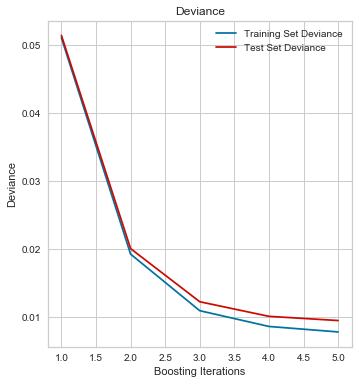

In [15]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error

# #############################################################################
# Load data
#boston = datasets.load_boston()
#X, y = shuffle(boston.data, boston.target, random_state=13)
#X = X.astype(np.float32)
#offset = int(X.shape[0] * 0.9)
#X_train, y_train = X[:offset], y[:offset]
#X_test, y_test = X[offset:], y[offset:]

# #############################################################################
# Fit regression model
params = {'n_estimators': 5, 'max_depth': 4, 'min_samples_split': 2,
          'learning_rate': 0.5, 'loss': 'ls'}
clf = ensemble.GradientBoostingRegressor(**params)

clf.fit(X_train, y_train)
mse = mean_squared_error(y_test, clf.predict(X_test))
print("MSE: %.4f" % mse)

# #############################################################################
# Plot training deviance

# compute test set deviance
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)

for i, y_pred in enumerate(clf.staged_predict(X_test)):
    test_score[i] = clf.loss_(y_test, y_pred)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, clf.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')

## RANDOM_FOREST

In [12]:
import pandas as pd
import numpy as np
import warnings
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.over_sampling import RandomOverSampler

In [13]:
#READ AND DROP COLUMNS
y = df['Occupancy']
X = df.drop(columns=['Occupancy'])

# Split the dataset in two equal parts
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1000,  stratify = y)

# Set the parameters by cross-validation
tuned_parameters = {
#    'criterion' : ['gini', 'entropy'],
#    'max_depth': [None, 10, 11, 15, 20],
#    'min_samples_split': [2, 5, 10, 20],
#    'min_samples_leaf': [1, 5, 10, 20]
    'n_estimators': [25, 50, 75, 100,  200, 500, 1000]
}
#scores = ['precision', 'recall', 'f1']
scores = ['accuracy']#, 'recall', 'f1']

for score in scores:
    print("# Tuning hyper-parameters for ----> %s" % score)
    print()
    
    obj = RandomForestClassifier()
    
    clf = GridSearchCV(obj, tuned_parameters, cv=5, scoring=score)

    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()

# Tuning hyper-parameters for ----> accuracy

Best parameters set found on development set:

{'n_estimators': 1000}

Grid scores on development set:

0.993 (+/-0.002) for {'n_estimators': 25}
0.993 (+/-0.002) for {'n_estimators': 50}
0.993 (+/-0.003) for {'n_estimators': 75}
0.993 (+/-0.002) for {'n_estimators': 100}
0.993 (+/-0.002) for {'n_estimators': 200}
0.993 (+/-0.003) for {'n_estimators': 500}
0.993 (+/-0.002) for {'n_estimators': 1000}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

           0       1.00      0.99      1.00      4743
           1       0.98      0.99      0.98      1425

    accuracy                           0.99      6168
   macro avg       0.99      0.99      0.99      6168
weighted avg       0.99      0.99      0.99      6168




**** Matrice di Confusione *****
 True negative: 4715 False negative: 15
 True positive: 1410 False positive: 28
____________________________________________
***** Calcolo dell'accuracy *****
Frazione di campioni correttamente correlati: 0.9930
Numero di campioni correttamente correlati:  6125
____________________________________________
**** Calcolo della precisione *****
Percentuale di classificazioni positive che sono corrette: 0.9805
____________________________________________
**** Calcolo della recall (sensitivity) *****
Percentuale di elementi positivi del testing set che sono stati classificati come positivi: 0.9895
____________________________________________
**** Calcolo della specificity *****
Percentuale di elementi negativi del testing set che sono stati classificati come negativi: 0.9941
____________________________________________
**** Calcolo della F1 score *****
F1 scores: 0.9850
____________________________________________
              precision    recall  f1-score  

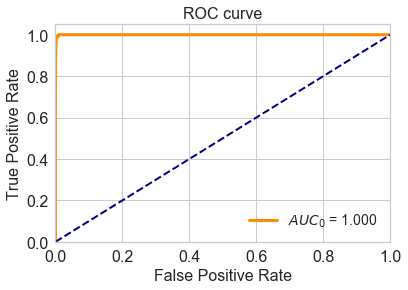

____________________________________
****** VALORE DI AUC *******
0.9996565205972976
____________________________________
****** ROC CURVE: con metodo diretto *******


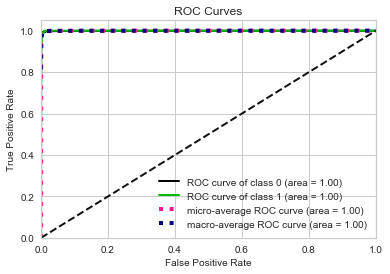

____________________________________
****** Precision recall: con metodo diretto *******


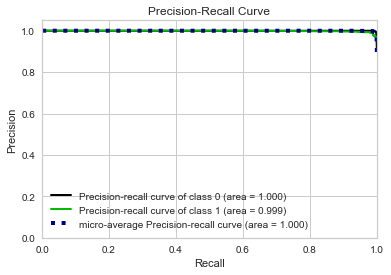

____________________________________
****** Cumulative gain: con metodo diretto *******


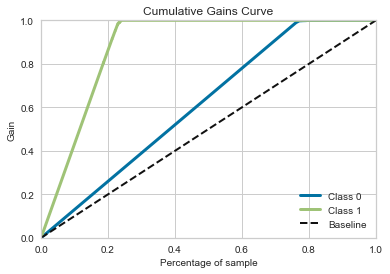

____________________________________
****** Lift curve: con metodo diretto *******


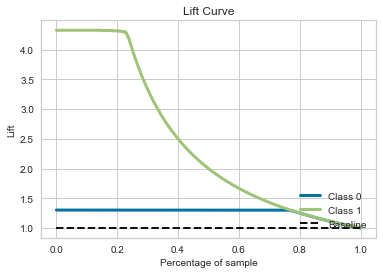

In [14]:
y = df['Occupancy']
X = df.drop(columns=['Occupancy'])

# Split the dataset in two equal parts
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1000, stratify = y)

clf = RandomForestClassifier(n_estimators = 500)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
result_pred(y_test, y_pred)
y_score = clf.predict_proba(X_test)
plot_res(y_pred, y_score, y_test)

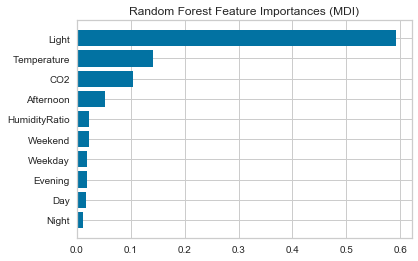

In [15]:
feature_names = ["Temperature", "Light", "CO2", "HumidityRatio", "Day", "Afternoon", "Evening", "Night", "Weekday", "Weekend"]
nbr_features = 10

tree_feature_importances = clf.feature_importances_
sorted_idx = tree_feature_importances.argsort()[-nbr_features:]

y_ticks = np.arange(0, len(sorted_idx))
fig, ax = plt.subplots()
plt.barh(y_ticks, tree_feature_importances[sorted_idx])
plt.yticks(y_ticks, np.array(feature_names)[sorted_idx])
plt.title("Random Forest Feature Importances (MDI)")
plt.show()

In [13]:
from sklearn.inspection import permutation_importance

In [14]:
result = permutation_importance(clf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2)

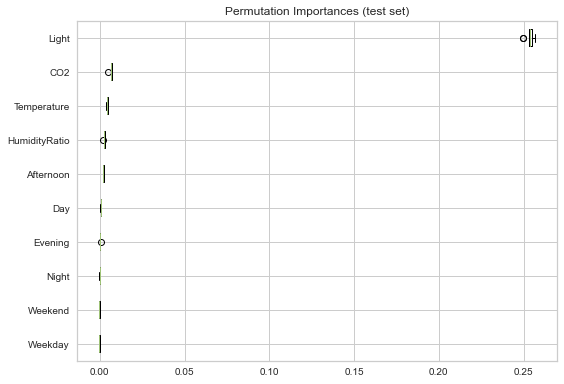

In [15]:
sorted_idx = result.importances_mean.argsort()[-nbr_features:]

fig, ax = plt.subplots()
plt.boxplot(result.importances[sorted_idx].T, vert=False, labels=np.array(feature_names)[sorted_idx])
plt.title("Permutation Importances (test set)")
plt.tight_layout()
plt.show()

In [16]:
import pydotplus
from sklearn import tree
from IPython.display import Image

In [22]:
dot_data = tree.export_graphviz(clf.estimators_[0], out_file=None,  
                                feature_names=feature_names, 
                                class_names=['Occupancy'],  
                                filled=True, rounded=True,  
                                special_characters=True, max_depth=4)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

ValueError: Length of feature_names, 11 does not match number of features, 10

## RANDOM_FOREST + Oversampling

In [17]:
from imblearn.over_sampling import RandomOverSampler

In [18]:
from collections import Counter
# READ AND DROP COLUMNS
y = df['Occupancy']
X = df.drop(columns=['Occupancy'])
ros = RandomOverSampler(random_state=42)
X_res, y_res = ros.fit_resample(X, y)
print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({1: 15810, 0: 15810})


In [19]:
# Split the dataset in two equal parts
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.3, random_state=1000,  stratify = y_res)

# Set the parameters by cross-validation
tuned_parameters = {
    #'criterion' : ['gini', 'entropy'],

    #'min_samples_split': [2, 5, 10, 20],
    #'min_samples_leaf': [1, 5, 10, 20]
    'n_estimators': [25, 50, 100,  200, 500, 1000]
}

#scores = ['precision', 'recall', 'f1']
scores = ['accuracy']

for score in scores:
    print("# Tuning hyper-parameters for ----> %s" % score)
    print()
    
    obj = RandomForestClassifier()
    
   
    clf = GridSearchCV(obj, param_grid=tuned_parameters, cv=5, scoring=score)
    
                         
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()

# Tuning hyper-parameters for ----> accuracy

Best parameters set found on development set:

{'n_estimators': 100}

Grid scores on development set:

0.995 (+/-0.002) for {'n_estimators': 25}
0.995 (+/-0.002) for {'n_estimators': 50}
0.995 (+/-0.002) for {'n_estimators': 100}
0.995 (+/-0.002) for {'n_estimators': 200}
0.995 (+/-0.002) for {'n_estimators': 500}
0.995 (+/-0.001) for {'n_estimators': 1000}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

           0       1.00      0.99      1.00      4743
           1       0.99      1.00      1.00      4743

    accuracy                           1.00      9486
   macro avg       1.00      1.00      1.00      9486
weighted avg       1.00      1.00      1.00      9486




In [20]:
clf = RandomForestClassifier(n_estimators = 100)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
result_pred(y_test, y_pred)


**** Matrice di Confusione *****
 True negative: 4710 False negative: 4
 True positive: 4739 False positive: 33
____________________________________________
***** Calcolo dell'accuracy *****
Frazione di campioni correttamente correlati: 0.9961
Numero di campioni correttamente correlati:  9449
____________________________________________
**** Calcolo della precisione *****
Percentuale di classificazioni positive che sono corrette: 0.9931
____________________________________________
**** Calcolo della recall (sensitivity) *****
Percentuale di elementi positivi del testing set che sono stati classificati come positivi: 0.9992
____________________________________________
**** Calcolo della specificity *****
Percentuale di elementi negativi del testing set che sono stati classificati come negativi: 0.9930
____________________________________________
**** Calcolo della F1 score *****
F1 scores: 0.9961
____________________________________________
              precision    recall  f1-score   

## RANDOM_FOREST + Undersampling

In [23]:
from collections import Counter
ros = RandomUnderSampler(random_state=42)
X_res, y_res = ros.fit_resample(X, y)
print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({0: 4750, 1: 4750})


In [24]:
# Split the dataset in two equal parts
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.3, random_state=1000,  stratify = y_res)

# Set the parameters by cross-validation
tuned_parameters = {
    #'criterion' : ['gini', 'entropy'],

    #'min_samples_split': [2, 5, 10, 20],
    #'min_samples_leaf': [1, 5, 10, 20]
    'n_estimators': [25, 50, 100,  200, 500, 1000]
}


#scores = ['precision', 'recall', 'f1']
scores = ['accuracy']

for score in scores:
    print("# Tuning hyper-parameters for ----> %s" % score)
    print()
    
    obj = RandomForestClassifier()
    
   
    clf = GridSearchCV(obj, param_grid=tuned_parameters, cv=5, scoring=score)
    
                         
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()

# Tuning hyper-parameters for ----> accuracy

Best parameters set found on development set:

{'n_estimators': 500}

Grid scores on development set:

0.992 (+/-0.003) for {'n_estimators': 25}
0.991 (+/-0.005) for {'n_estimators': 50}
0.992 (+/-0.004) for {'n_estimators': 100}
0.991 (+/-0.004) for {'n_estimators': 200}
0.992 (+/-0.003) for {'n_estimators': 500}
0.992 (+/-0.004) for {'n_estimators': 1000}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1425
           1       1.00      1.00      1.00      1425

    accuracy                           1.00      2850
   macro avg       1.00      1.00      1.00      2850
weighted avg       1.00      1.00      1.00      2850




In [25]:
clf = RandomForestClassifier(n_estimators = 500)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
result_pred(y_test, y_pred)

**** Matrice di Confusione *****
 True negative: 1421 False negative: 6
 True positive: 1419 False positive: 4
____________________________________________
***** Calcolo dell'accuracy *****
Frazione di campioni correttamente correlati: 0.9965
Numero di campioni correttamente correlati:  2840
____________________________________________
**** Calcolo della precisione *****
Percentuale di classificazioni positive che sono corrette: 0.9972
____________________________________________
**** Calcolo della recall (sensitivity) *****
Percentuale di elementi positivi del testing set che sono stati classificati come positivi: 0.9958
____________________________________________
**** Calcolo della specificity *****
Percentuale di elementi negativi del testing set che sono stati classificati come negativi: 0.9972
____________________________________________
**** Calcolo della F1 score *****
F1 scores: 0.9965
____________________________________________
              precision    recall  f1-score   s

# Bagging

In [24]:
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

## GridSearch - Gauss

# Bagging-GAUSSIAN

In [30]:
attributes = ['Light','CO2','HumidityRatio', 'Day']
y = df['Occupancy']
X = df[attributes]
#X = df.drop(columns=['Occupancy'])
# Split the dataset in two equal parts
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1000, stratify = y)

# Set the parameters by cross-validation
param_grid = {
    'max_features' : [1, 2, 3, 4],
    'max_samples' : [0.05, 0.02, 0.01, 0.1, 0.2, 0.5, 1.0],
    'n_estimators': [1, 5, 10, 25, 50, 100]
}

#scores = ['precision', 'recall', 'f1']
scores = ['f1']

for score in scores:
    print("# Tuning hyper-parameters for ----> %s" % score)
    print()
    
    clf = GridSearchCV(BaggingClassifier(GaussianNB()), param_grid, scoring = score)
    clf.fit(X_train, y_train)
    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()

# Tuning hyper-parameters for ----> f1

Best parameters set found on development set:

{'max_features': 2, 'max_samples': 0.01, 'n_estimators': 100}

Grid scores on development set:

0.328 (+/-0.697) for {'max_features': 1, 'max_samples': 0.05, 'n_estimators': 1}
0.565 (+/-0.379) for {'max_features': 1, 'max_samples': 0.05, 'n_estimators': 5}
0.720 (+/-0.378) for {'max_features': 1, 'max_samples': 0.05, 'n_estimators': 10}
0.487 (+/-0.288) for {'max_features': 1, 'max_samples': 0.05, 'n_estimators': 25}
0.611 (+/-0.214) for {'max_features': 1, 'max_samples': 0.05, 'n_estimators': 50}
0.597 (+/-0.127) for {'max_features': 1, 'max_samples': 0.05, 'n_estimators': 100}
0.247 (+/-0.302) for {'max_features': 1, 'max_samples': 0.02, 'n_estimators': 1}
0.466 (+/-0.699) for {'max_features': 1, 'max_samples': 0.02, 'n_estimators': 5}
0.609 (+/-0.284) for {'max_features': 1, 'max_samples': 0.02, 'n_estimators': 10}
0.586 (+/-0.239) for {'max_features': 1, 'max_samples': 0.02, 'n_estimators': 25}


**** Matrice di Confusione *****
 True negative: 4628 False negative: 4
 True positive: 1421 False positive: 115
____________________________________________
***** Calcolo dell'accuracy *****
Frazione di campioni correttamente correlati: 0.9807
Numero di campioni correttamente correlati:  6049
____________________________________________
**** Calcolo della precisione *****
Percentuale di classificazioni positive che sono corrette: 0.9251
____________________________________________
**** Calcolo della recall (sensitivity) *****
Percentuale di elementi positivi del testing set che sono stati classificati come positivi: 0.9972
____________________________________________
**** Calcolo della specificity *****
Percentuale di elementi negativi del testing set che sono stati classificati come negativi: 0.9758
____________________________________________
**** Calcolo della F1 score *****
F1 scores: 0.9598
____________________________________________
              precision    recall  f1-score  

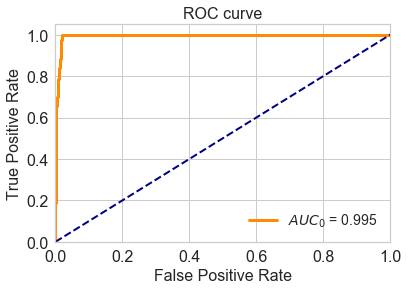

____________________________________
****** VALORE DI AUC *******
0.9952461799660441
____________________________________
****** ROC CURVE: con metodo diretto *******


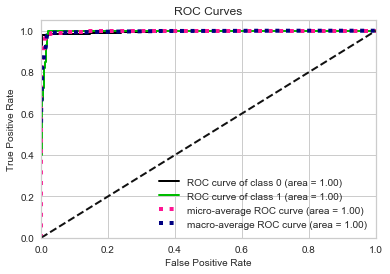

____________________________________
****** Precision recall: con metodo diretto *******


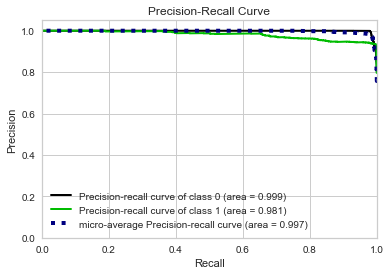

____________________________________
****** Cumulative gain: con metodo diretto *******


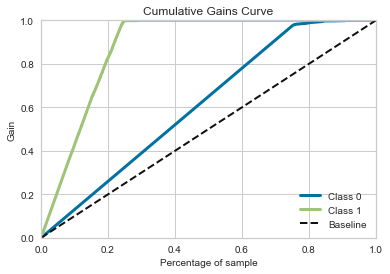

____________________________________
****** Lift curve: con metodo diretto *******


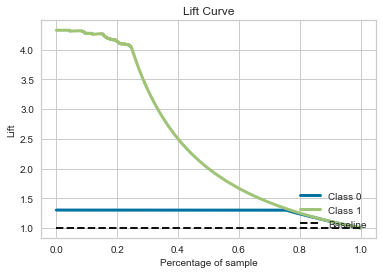

In [31]:
attributes = ['Light','CO2','HumidityRatio', 'Day']
y = df['Occupancy']
X = df[attributes]
# Split the dataset in two equal parts
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1000, stratify = y)

clf = BaggingClassifier(GaussianNB(), max_features = 2, max_samples = 0.01, n_estimators = 100)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
result_pred(y_test, y_pred)
y_score = clf.predict_proba(X_test)
plot_res(y_pred, y_score, y_test)

# Bagging DecisionTree


In [28]:
from sklearn.tree import DecisionTreeClassifier

attributes = ['Temperature', 'Light','CO2', 'HumidityRatio','Day','Afternoon', 'Evening', 'Night', 'Weekday','Weekend']
y = df['Occupancy']
X = df[attributes]
#X = df.drop(columns=['Occupancy'])
# Split the dataset in two equal parts
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1000, stratify = y)

# Set the parameters by cross-validation
param_grid = {
    'max_features' : [1, 2, 3, 4],
    'max_samples' : [0.05, 0.02, 0.01, 0.1, 0.2, 0.5, 1.0],
    'n_estimators': [1, 5, 10, 25, 50, 100]
}

#scores = ['precision', 'recall', 'f1']
scores = ['f1']

for score in scores:
    print("# Tuning hyper-parameters for ----> %s" % score)
    print()
    
    clf = GridSearchCV(BaggingClassifier(DecisionTreeClassifier(criterion='gini', max_depth= 5, min_samples_leaf= 5, min_samples_split= 5)), param_grid, scoring = score)
    clf.fit(X_train, y_train)
    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()

# Tuning hyper-parameters for ----> f1

Best parameters set found on development set:

{'max_features': 4, 'max_samples': 0.1, 'n_estimators': 25}

Grid scores on development set:

0.226 (+/-0.476) for {'max_features': 1, 'max_samples': 0.05, 'n_estimators': 1}
0.518 (+/-0.682) for {'max_features': 1, 'max_samples': 0.05, 'n_estimators': 5}
0.436 (+/-0.672) for {'max_features': 1, 'max_samples': 0.05, 'n_estimators': 10}
0.277 (+/-0.477) for {'max_features': 1, 'max_samples': 0.05, 'n_estimators': 25}
0.307 (+/-0.345) for {'max_features': 1, 'max_samples': 0.05, 'n_estimators': 50}
0.236 (+/-0.404) for {'max_features': 1, 'max_samples': 0.05, 'n_estimators': 100}
0.413 (+/-0.744) for {'max_features': 1, 'max_samples': 0.02, 'n_estimators': 1}
0.279 (+/-0.576) for {'max_features': 1, 'max_samples': 0.02, 'n_estimators': 5}
0.258 (+/-0.635) for {'max_features': 1, 'max_samples': 0.02, 'n_estimators': 10}
0.241 (+/-0.394) for {'max_features': 1, 'max_samples': 0.02, 'n_estimators': 25}
0.

**** Matrice di Confusione *****
 True negative: 4675 False negative: 59
 True positive: 1366 False positive: 68
____________________________________________
***** Calcolo dell'accuracy *****
Frazione di campioni correttamente correlati: 0.9794
Numero di campioni correttamente correlati:  6041
____________________________________________
**** Calcolo della precisione *****
Percentuale di classificazioni positive che sono corrette: 0.9526
____________________________________________
**** Calcolo della recall (sensitivity) *****
Percentuale di elementi positivi del testing set che sono stati classificati come positivi: 0.9586
____________________________________________
**** Calcolo della specificity *****
Percentuale di elementi negativi del testing set che sono stati classificati come negativi: 0.9857
____________________________________________
**** Calcolo della F1 score *****
F1 scores: 0.9556
____________________________________________
              precision    recall  f1-score  

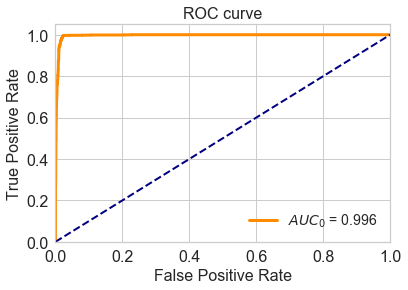

____________________________________
****** VALORE DI AUC *******
0.9960612684990994
____________________________________
****** ROC CURVE: con metodo diretto *******


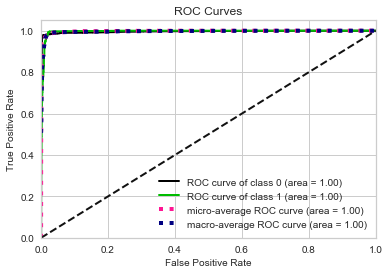

____________________________________
****** Precision recall: con metodo diretto *******


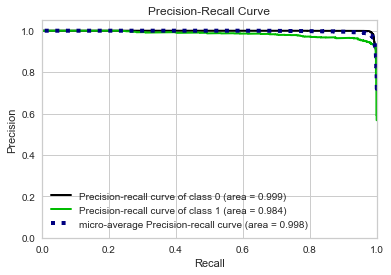

____________________________________
****** Cumulative gain: con metodo diretto *******


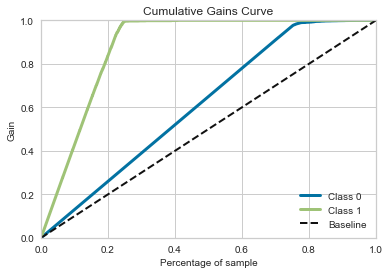

____________________________________
****** Lift curve: con metodo diretto *******


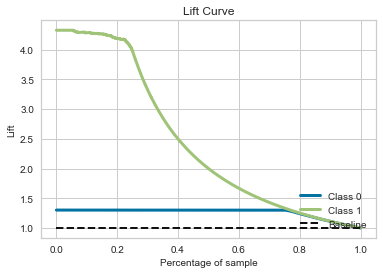

In [33]:
attributes = ['Temperature', 'Light','CO2', 'HumidityRatio','Day','Afternoon', 'Evening', 'Night', 'Weekday','Weekend']
y = df['Occupancy']
X = df[attributes]
#Split the dataset in two equal parts
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1000, stratify = y)

clf = BaggingClassifier(DecisionTreeClassifier(criterion='gini', max_depth= 5, min_samples_leaf= 5, min_samples_split= 5), max_features = 4, max_samples = 0.1, n_estimators = 25)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
result_pred(y_test, y_pred)
y_score = clf.predict_proba(X_test)
plot_res(y_pred, y_score, y_test)

# Bagging KNN

In [32]:
from sklearn.neighbors import KNeighborsClassifier

attributes = ['Temperature', 'Light','CO2', 'HumidityRatio','Day','Afternoon', 'Evening', 'Night', 'Weekday','Weekend']
y = df['Occupancy']
X = df[attributes]
#X = df.drop(columns=['Occupancy'])
# Split the dataset in two equal parts
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1000, stratify = y)

# Set the parameters by cross-validation
param_grid = {
    'max_features' : [1, 2, 3, 4],
    'max_samples' : [0.05, 0.02, 0.01, 0.1, 0.2, 0.5, 1.0],
    'n_estimators': [1, 5, 10, 25, 50, 100]
}

#scores = ['precision', 'recall', 'f1']
scores = ['f1']

for score in scores:
    print("# Tuning hyper-parameters for ----> %s" % score)
    print()
    
    clf = GridSearchCV(BaggingClassifier(KNeighborsClassifier()), param_grid, scoring = score)
    clf.fit(X_train, y_train)
    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()

# Tuning hyper-parameters for ----> f1

Best parameters set found on development set:

{'max_features': 4, 'max_samples': 1.0, 'n_estimators': 25}

Grid scores on development set:

0.357 (+/-0.590) for {'max_features': 1, 'max_samples': 0.05, 'n_estimators': 1}
0.434 (+/-0.712) for {'max_features': 1, 'max_samples': 0.05, 'n_estimators': 5}
0.637 (+/-0.245) for {'max_features': 1, 'max_samples': 0.05, 'n_estimators': 10}
0.346 (+/-0.376) for {'max_features': 1, 'max_samples': 0.05, 'n_estimators': 25}
0.368 (+/-0.514) for {'max_features': 1, 'max_samples': 0.05, 'n_estimators': 50}
0.337 (+/-0.215) for {'max_features': 1, 'max_samples': 0.05, 'n_estimators': 100}
0.371 (+/-0.607) for {'max_features': 1, 'max_samples': 0.02, 'n_estimators': 1}
0.198 (+/-0.369) for {'max_features': 1, 'max_samples': 0.02, 'n_estimators': 5}
0.306 (+/-0.355) for {'max_features': 1, 'max_samples': 0.02, 'n_estimators': 10}
0.489 (+/-0.468) for {'max_features': 1, 'max_samples': 0.02, 'n_estimators': 25}
0.

              precision    recall  f1-score   support

           0       1.00      0.99      1.00      4743
           1       0.98      0.99      0.99      1425

    accuracy                           0.99      6168
   macro avg       0.99      0.99      0.99      6168
weighted avg       0.99      0.99      0.99      6168




**** Matrice di Confusione *****
 True negative: 4678 False negative: 62
 True positive: 1363 False positive: 65
____________________________________________
***** Calcolo dell'accuracy *****
Frazione di campioni correttamente correlati: 0.9794
Numero di campioni correttamente correlati:  6041
____________________________________________
**** Calcolo della precisione *****
Percentuale di classificazioni positive che sono corrette: 0.9545
____________________________________________
**** Calcolo della recall (sensitivity) *****
Percentuale di elementi positivi del testing set che sono stati classificati come positivi: 0.9565
____________________________________________
**** Calcolo della specificity *****
Percentuale di elementi negativi del testing set che sono stati classificati come negativi: 0.9863
____________________________________________
**** Calcolo della F1 score *****
F1 scores: 0.9555
____________________________________________
              precision    recall  f1-score  

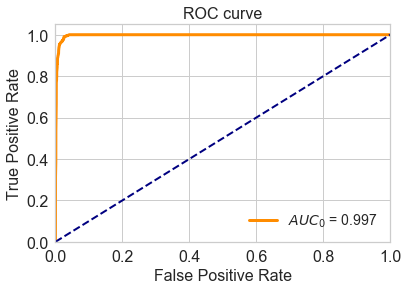

____________________________________
****** VALORE DI AUC *******
0.9970517586396943
____________________________________
****** ROC CURVE: con metodo diretto *******


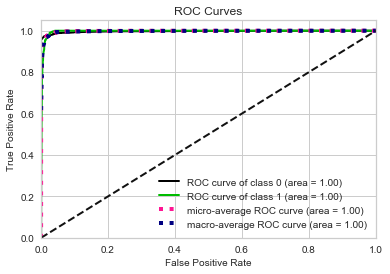

____________________________________
****** Precision recall: con metodo diretto *******


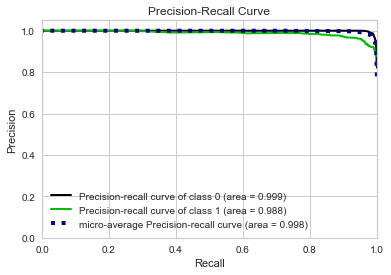

____________________________________
****** Cumulative gain: con metodo diretto *******


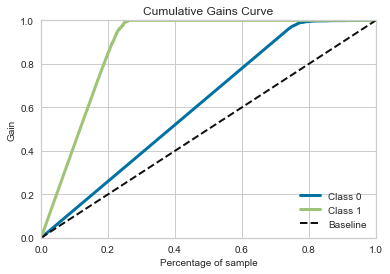

____________________________________
****** Lift curve: con metodo diretto *******


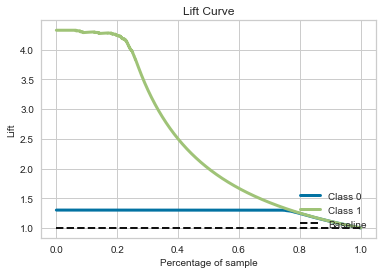

In [34]:
attributes = ['Temperature', 'Light','CO2', 'HumidityRatio','Day','Afternoon', 'Evening', 'Night', 'Weekday','Weekend']
y = df['Occupancy']
X = df[attributes]
#Split the dataset in two equal parts
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1000, stratify = y)

clf = BaggingClassifier(KNeighborsClassifier(), max_features = 4, max_samples = 0.1, n_estimators = 25)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
result_pred(y_test, y_pred)
y_score = clf.predict_proba(X_test)
plot_res(y_pred, y_score, y_test)

# LogisticRegression-Bagging

In [38]:
from sklearn.linear_model import LogisticRegression

attributes = ['Temperature', 'Light','CO2', 'HumidityRatio','Day','Afternoon', 'Evening', 'Night', 'Weekday','Weekend']
y = df['Occupancy']
X = df[attributes]
#X = df.drop(columns=['Occupancy'])
# Split the dataset in two equal parts
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1000, stratify = y)

# Set the parameters by cross-validation
param_grid = {
    'max_features' : [1, 2, 3, 4],
    'max_samples' : [0.05, 0.02, 0.01, 0.1, 0.2, 0.5, 1.0],
    'n_estimators': [1, 5, 10, 25, 50, 100]
}

#scores = ['precision', 'recall', 'f1']
scores = ['f1']

for score in scores:
    print("# Tuning hyper-parameters for ----> %s" % score)
    print()
    
    clf = GridSearchCV(BaggingClassifier(LogisticRegression()), param_grid, scoring = score)
    clf.fit(X_train, y_train)
    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()

# Tuning hyper-parameters for ----> f1

Best parameters set found on development set:

{'max_features': 4, 'max_samples': 0.1, 'n_estimators': 5}

Grid scores on development set:

0.122 (+/-0.489) for {'max_features': 1, 'max_samples': 0.05, 'n_estimators': 1}
0.232 (+/-0.319) for {'max_features': 1, 'max_samples': 0.05, 'n_estimators': 5}
0.146 (+/-0.220) for {'max_features': 1, 'max_samples': 0.05, 'n_estimators': 10}
0.024 (+/-0.061) for {'max_features': 1, 'max_samples': 0.05, 'n_estimators': 25}
0.000 (+/-0.000) for {'max_features': 1, 'max_samples': 0.05, 'n_estimators': 50}
0.000 (+/-0.000) for {'max_features': 1, 'max_samples': 0.05, 'n_estimators': 100}
0.196 (+/-0.782) for {'max_features': 1, 'max_samples': 0.02, 'n_estimators': 1}
0.003 (+/-0.012) for {'max_features': 1, 'max_samples': 0.02, 'n_estimators': 5}
0.030 (+/-0.080) for {'max_features': 1, 'max_samples': 0.02, 'n_estimators': 10}
0.000 (+/-0.000) for {'max_features': 1, 'max_samples': 0.02, 'n_estimators': 25}
0.0

**** Matrice di Confusione *****
 True negative: 4668 False negative: 147
 True positive: 1278 False positive: 75
____________________________________________
***** Calcolo dell'accuracy *****
Frazione di campioni correttamente correlati: 0.9640
Numero di campioni correttamente correlati:  5946
____________________________________________
**** Calcolo della precisione *****
Percentuale di classificazioni positive che sono corrette: 0.9446
____________________________________________
**** Calcolo della recall (sensitivity) *****
Percentuale di elementi positivi del testing set che sono stati classificati come positivi: 0.8968
____________________________________________
**** Calcolo della specificity *****
Percentuale di elementi negativi del testing set che sono stati classificati come negativi: 0.9842
____________________________________________
**** Calcolo della F1 score *****
F1 scores: 0.9201
____________________________________________
              precision    recall  f1-score 

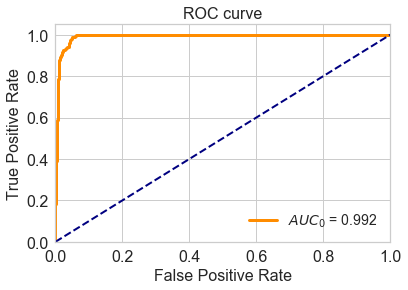

____________________________________
****** VALORE DI AUC *******
0.9920785941239352
____________________________________
****** ROC CURVE: con metodo diretto *******


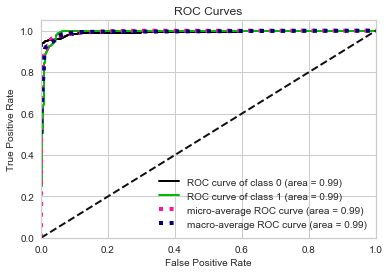

____________________________________
****** Precision recall: con metodo diretto *******


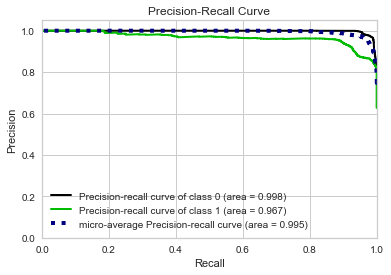

____________________________________
****** Cumulative gain: con metodo diretto *******


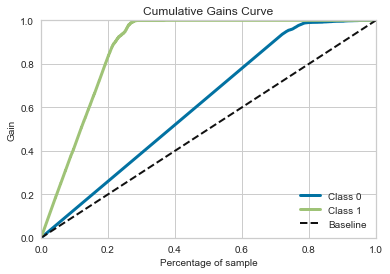

____________________________________
****** Lift curve: con metodo diretto *******


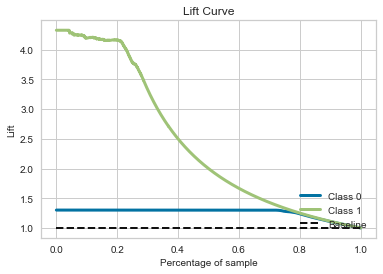

In [39]:
attributes = ['Temperature', 'Light','CO2', 'HumidityRatio','Day','Afternoon', 'Evening', 'Night', 'Weekday','Weekend']
y = df['Occupancy']
X = df[attributes]
#Split the dataset in two equal parts
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1000, stratify = y)

clf = BaggingClassifier(LogisticRegression(), max_features = 4, max_samples = 0.1, n_estimators = 5)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
result_pred(y_test, y_pred)
y_score = clf.predict_proba(X_test)
plot_res(y_pred, y_score, y_test)

# Bagging - Oversampling

In [29]:
from collections import Counter
ros = RandomOverSampler(random_state=42)
X_res, y_res = ros.fit_resample(X, y)
print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({1: 15810, 0: 15810})


In [77]:

# Split the dataset in two equal parts
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.3, random_state=1000, stratify = y_res)

# Set the parameters by cross-validation
param_grid = {
    'max_features' : [1, 2, 3, 4],
    'max_samples' : [0.05, 0.02, 0.01, 0.1, 0.2, 0.5, 1.0]
}

#scores = ['precision', 'recall', 'f1']
scores = ['accuracy']

for score in scores:
    print("# Tuning hyper-parameters for ----> %s" % score)
    print()
    
    clf = GridSearchCV(BaggingClassifier(KNeighborsClassifier(n_neighbors=5)), param_grid, scoring = score)
    clf.fit(X_train, y_train)
    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()

# Tuning hyper-parameters for ----> accuracy

Best parameters set found on development set:

{'max_features': 4, 'max_samples': 1.0}

Grid scores on development set:

0.942 (+/-0.113) for {'max_features': 1, 'max_samples': 0.05}
0.922 (+/-0.101) for {'max_features': 1, 'max_samples': 0.02}
0.905 (+/-0.179) for {'max_features': 1, 'max_samples': 0.01}
0.943 (+/-0.092) for {'max_features': 1, 'max_samples': 0.1}
0.977 (+/-0.040) for {'max_features': 1, 'max_samples': 0.2}
0.967 (+/-0.035) for {'max_features': 1, 'max_samples': 0.5}
0.963 (+/-0.067) for {'max_features': 1, 'max_samples': 1.0}
0.990 (+/-0.006) for {'max_features': 2, 'max_samples': 0.05}
0.986 (+/-0.005) for {'max_features': 2, 'max_samples': 0.02}
0.972 (+/-0.050) for {'max_features': 2, 'max_samples': 0.01}
0.990 (+/-0.006) for {'max_features': 2, 'max_samples': 0.1}
0.992 (+/-0.003) for {'max_features': 2, 'max_samples': 0.2}
0.988 (+/-0.010) for {'max_features': 2, 'max_samples': 0.5}
0.988 (+/-0.015) for {'max_feature

**** Matrice di Confusione *****
 True negative: 4071 False negative: 78
 True positive: 4665 False positive: 672
____________________________________________
***** Calcolo dell'accuracy *****
Frazione di campioni correttamente correlati: 0.9209
Numero di campioni correttamente correlati:  8736
____________________________________________
**** Calcolo della precisione *****
Percentuale di classificazioni positive che sono corrette: 0.8741
____________________________________________
**** Calcolo della recall (sensitivity) *****
Percentuale di elementi positivi del testing set che sono stati classificati come positivi: 0.9836
____________________________________________
**** Calcolo della specificity *****
Percentuale di elementi negativi del testing set che sono stati classificati come negativi: 0.8583
____________________________________________
**** Calcolo della F1 score *****
F1 scores: 0.9256
____________________________________________
              precision    recall  f1-score 

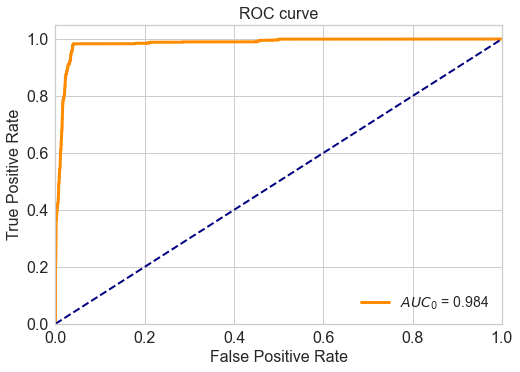

____________________________________
****** VALORE DI AUC *******
0.9839169980470793
____________________________________
****** ROC CURVE: con metodo diretto *******


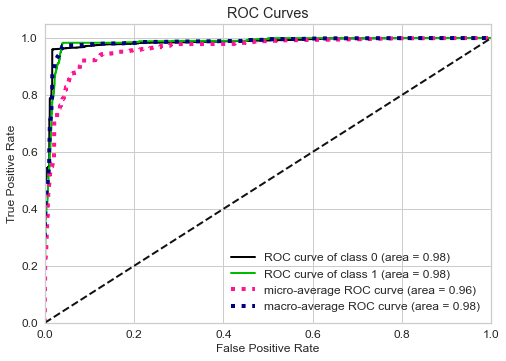

____________________________________
****** Precision recall: con metodo diretto *******


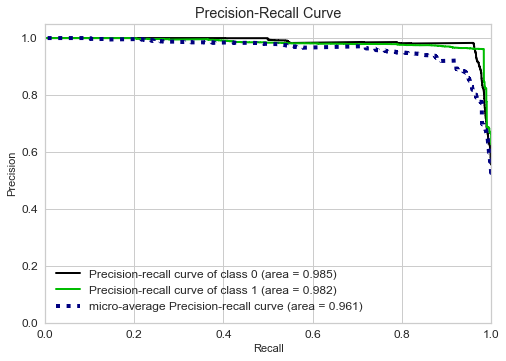

____________________________________
****** Cumulative gain: con metodo diretto *******


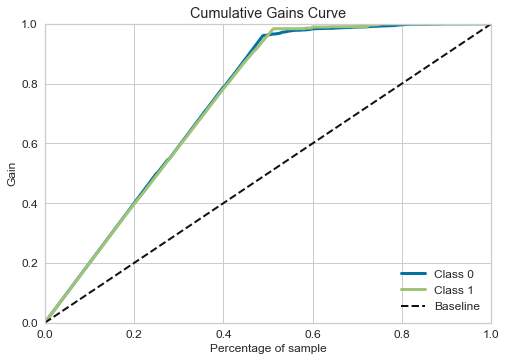

____________________________________
****** Lift curve: con metodo diretto *******


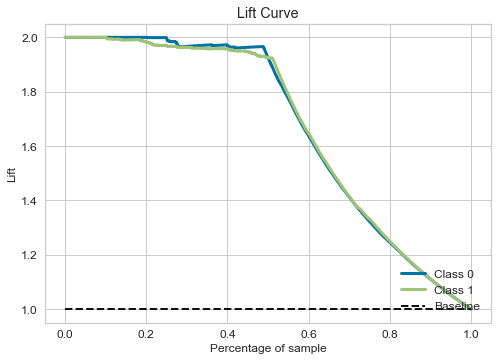

In [33]:
# Split the dataset in two equal parts
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.3, random_state=1000, stratify = y_res)

clf = BaggingClassifier(GaussianNB(), max_features = 4, max_samples = 1.0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
result_pred(y_test, y_pred)
y_score = clf.predict_proba(X_test)
plot_res(y_pred, y_score, y_test)

# Bagging - Undersampling

In [34]:
from collections import Counter
ros = RandomUnderSampler(random_state=42)
X_res, y_res = ros.fit_resample(X, y)
print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({0: 4750, 1: 4750})


In [80]:
# Split the dataset in two equal parts
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.3, random_state=1000, stratify = y_res)

# Set the parameters by cross-validation
param_grid = {
    'max_features' : [1, 2, 3, 4],
    'max_samples' : [0.05, 0.02, 0.01, 0.1, 0.2, 0.5, 1.0]
}

#scores = ['precision', 'recall', 'f1']
scores = ['accuracy']

for score in scores:
    print("# Tuning hyper-parameters for ----> %s" % score)
    print()
    
    clf = GridSearchCV(BaggingClassifier(KNeighborsClassifier(n_neighbors=5)), param_grid, scoring = score)
    clf.fit(X_train, y_train)
    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()

# Tuning hyper-parameters for ----> accuracy

Best parameters set found on development set:

{'max_features': 4, 'max_samples': 0.5}

Grid scores on development set:

0.929 (+/-0.086) for {'max_features': 1, 'max_samples': 0.05}
0.920 (+/-0.099) for {'max_features': 1, 'max_samples': 0.02}
0.974 (+/-0.015) for {'max_features': 1, 'max_samples': 0.01}
0.946 (+/-0.116) for {'max_features': 1, 'max_samples': 0.1}
0.905 (+/-0.145) for {'max_features': 1, 'max_samples': 0.2}
0.930 (+/-0.066) for {'max_features': 1, 'max_samples': 0.5}
0.905 (+/-0.118) for {'max_features': 1, 'max_samples': 1.0}
0.975 (+/-0.022) for {'max_features': 2, 'max_samples': 0.05}
0.984 (+/-0.006) for {'max_features': 2, 'max_samples': 0.02}
0.977 (+/-0.008) for {'max_features': 2, 'max_samples': 0.01}
0.984 (+/-0.018) for {'max_features': 2, 'max_samples': 0.1}
0.982 (+/-0.020) for {'max_features': 2, 'max_samples': 0.2}
0.990 (+/-0.004) for {'max_features': 2, 'max_samples': 0.5}
0.984 (+/-0.015) for {'max_feature

**** Matrice di Confusione *****
 True negative: 875 False negative: 0
 True positive: 1425 False positive: 550
____________________________________________
***** Calcolo dell'accuracy *****
Frazione di campioni correttamente correlati: 0.8070
Numero di campioni correttamente correlati:  2300
____________________________________________
**** Calcolo della precisione *****
Percentuale di classificazioni positive che sono corrette: 0.7215
____________________________________________
**** Calcolo della recall (sensitivity) *****
Percentuale di elementi positivi del testing set che sono stati classificati come positivi: 1.0000
____________________________________________
**** Calcolo della specificity *****
Percentuale di elementi negativi del testing set che sono stati classificati come negativi: 0.6140
____________________________________________
**** Calcolo della F1 score *****
F1 scores: 0.8382
____________________________________________
              precision    recall  f1-score   

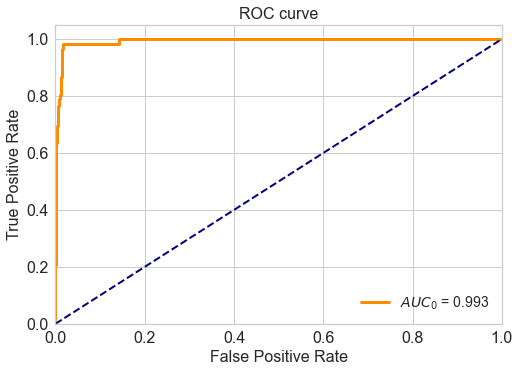

____________________________________
****** VALORE DI AUC *******
0.9932823638042474
____________________________________
****** ROC CURVE: con metodo diretto *******


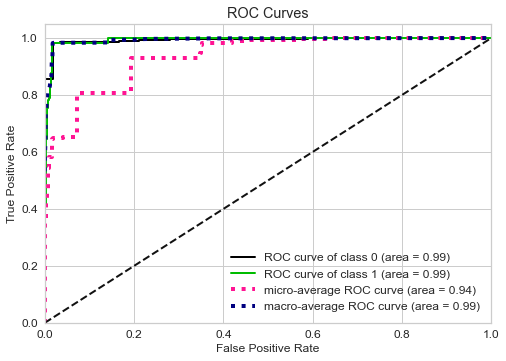

____________________________________
****** Precision recall: con metodo diretto *******


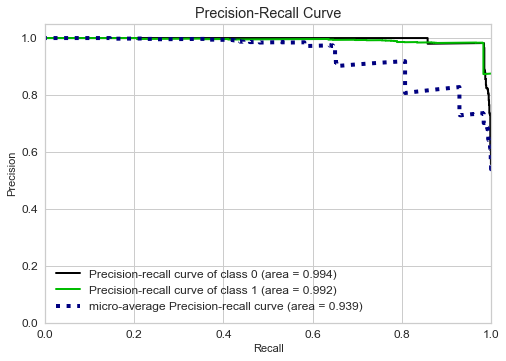

____________________________________
****** Cumulative gain: con metodo diretto *******


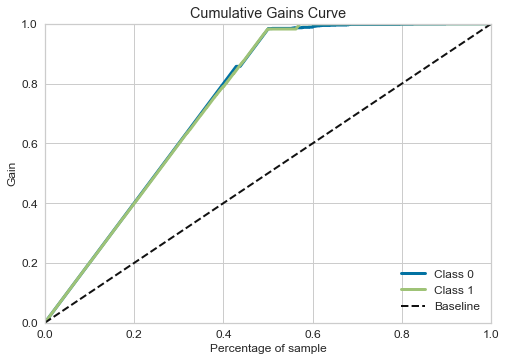

____________________________________
****** Lift curve: con metodo diretto *******


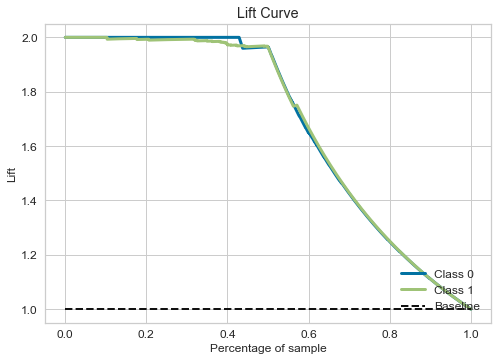

In [35]:
# Split the dataset in two equal parts
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.3, random_state=1000, stratify = y_res)

clf = BaggingClassifier(GaussianNB(), max_features = 4, max_samples = 0.5)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
result_pred(y_test, y_pred)
y_score = clf.predict_proba(X_test)
plot_res(y_pred, y_score, y_test)